# Amino acid preferences
This notebook takes codon counts and uses manually calculate the frequency of each codon at each mutagenezed site in the Zika Virus NS5 protein.

## Notebook setup
Imports

In [1]:
import dms_tools2
from IPython.display import display, HTML
import numpy as np
import os
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO
from dms_tools2.ipython_utils import showPDF

%matplotlib inline

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

dms_tools2==2.6.8
numpy==1.19.1
pandas==0.25.3
plotnine==0.6.0
regex==2.5.83


Input data

In [2]:
samplesheet = 'data/samplesheet.csv'
codon_counts_dir = 'results/codon_counts/'

Output data

In [3]:
results_dir = 'results/'

Analysis parameters

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

## Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
samples = samples.drop('r1_file', axis=1)
samples.insert(0, 'name', (samples['library'] + '-' +
                           samples['source'] + '-' +
                           samples['stage'] + '-' +
                           samples['sorted']))
display(samples)

,name,library,source,stage,sorted
0,wt-plasmid-noStage-notSorted,wt,plasmid,noStage,notSorted
1,wt-gDNA-noStage-notSorted,wt,gDNA,noStage,notSorted
2,lib1-plasmid-noStage-notSorted,lib1,plasmid,noStage,notSorted
3,lib2-plasmid-noStage-notSorted,lib2,plasmid,noStage,notSorted
4,lib3-plasmid-noStage-notSorted,lib3,plasmid,noStage,notSorted
5,lib1-gDNA-early-notSorted,lib1,gDNA,early,notSorted
6,lib2-gDNA-early-notSorted,lib2,gDNA,early,notSorted
7,lib3-gDNA-early-notSorted,lib3,gDNA,early,notSorted
8,lib1-gDNA-mid-notSorted,lib1,gDNA,mid,notSorted
9,lib2-gDNA-mid-notSorted,lib2,gDNA,mid,notSorted


# Calculate codon frequencies
Calculate the codon frequencies at each site in each mutagenized gDNA sample.

Setup:

In [6]:
# Set up results dir
codon_freqs_dir = os.path.join(results_dir + 'codon_freqs')
os.makedirs(codon_freqs_dir, exist_ok=True)

Load counts dataframe:

In [7]:
count_df = pd.read_csv('results/codon_counts/wt-plasmid-noStage-notSorted_codoncounts.csv')
display(count_df)

,site,wildtype,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,1,GGA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GGT,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,GGG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,ACG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,GGA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,TGT,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991,992,GAG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
992,993,CCT,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993,994,GCA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sum all counts at site and exclude sites with 0 counts:

In [8]:
count_df['site_total'] = (
    count_df.loc[:, count_df.columns!='site']
    .sum(axis=1, numeric_only=True))
count_df = (
    count_df.loc[count_df['site_total']!=0, :]
)
display(count_df)

,site,wildtype,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,site_total
650,651,AGC,0,28,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,138690
651,652,AAT,0,42,0,138718,0,0,0,2,...,0,0,0,0,0,0,0,0,0,138924
652,653,GGA,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,138870
653,654,TGG,0,0,0,0,0,0,0,0,...,0,48,2,138872,2,0,0,2,0,139029
654,655,GAT,0,0,0,35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,138597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,757,GCA,0,0,0,0,42,0,0,0,...,0,0,0,0,0,0,0,0,0,139167
757,758,AAA,138991,2,70,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,139184
758,759,TCA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,18,0,0,0,138525
759,760,TAT,0,0,0,0,0,0,0,0,...,2,0,0,0,75,0,0,0,1,138546


Check that every site is preserved within the range of observed sites:

In [9]:
assert count_df['site'].tolist() == \
    [x for x in range(count_df['site'].min(), (count_df['site'].max()+1))], \
    "missing site in range of observed sites"

Plot coverage of each site:

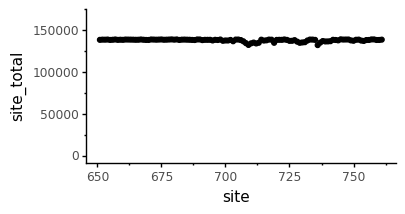

<ggplot: (8737351670409)>

In [10]:
site_coverage = (
    p9.ggplot(count_df,
              p9.aes(x='site',
                     y='site_total')) +
    p9.geom_point() +
    p9.ylim(0,1.2*max(count_df['site_total'])) +
    p9.theme(figure_size=(4, 2))
)
display(site_coverage)

Calculate frequency of each codon:

In [11]:
freq_df = count_df.copy()
freq_df.iloc[:, 2:-1] = freq_df.iloc[:, 2:-1].div(freq_df.site_total, axis=0)
display(freq_df)

,site,wildtype,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,site_total
650,651,AGC,0.000000,0.000202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000029,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138690
651,652,AAT,0.000000,0.000302,0.000000,0.998517,0.000000,0.0,0.000000,0.000014,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138924
652,653,GGA,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000014,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138870
653,654,TGG,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000345,0.000014,0.998871,0.000014,0.00000,0.0,0.000014,0.000000,139029
654,655,GAT,0.000000,0.000000,0.000000,0.000253,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,757,GCA,0.000000,0.000000,0.000000,0.000000,0.000302,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,139167
757,758,AAA,0.998613,0.000014,0.000503,0.000000,0.000022,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,139184
758,759,TCA,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00013,0.0,0.000000,0.000000,138525
759,760,TAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000014,0.000000,0.000000,0.000000,0.000541,0.00000,0.0,0.000000,0.000007,138546


Extract WT frequency at each site:

In [12]:
wt_freqs = list()
for index, row in freq_df.iterrows():
    wt_freqs.append(row[row['wildtype']])
wt_freqs_df = pd.Series(wt_freqs, name='wt_freq')
display(wt_freqs_df)

0      0.994419
1      0.998517
2      0.998481
3      0.998871
4      0.998131
         ...   
106    0.999116
107    0.998613
108    0.998953
109    0.998939
110    0.999208
Name: wt_freq, Length: 111, dtype: float64

Bring back into freqs_df:

In [13]:
freq_df = freq_df.assign(wt_freq=wt_freqs_df.values)
display(freq_df)

,site,wildtype,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,...,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,site_total,wt_freq
650,651,AGC,0.000000,0.000202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000029,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138690,0.994419
651,652,AAT,0.000000,0.000302,0.000000,0.998517,0.000000,0.0,0.000000,0.000014,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138924,0.998517
652,653,GGA,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000014,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138870,0.998481
653,654,TGG,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000345,0.000014,0.998871,0.000014,0.00000,0.0,0.000014,0.000000,139029,0.998871
654,655,GAT,0.000000,0.000000,0.000000,0.000253,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,138597,0.998131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,757,GCA,0.000000,0.000000,0.000000,0.000000,0.000302,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,139167,0.999116
757,758,AAA,0.998613,0.000014,0.000503,0.000000,0.000022,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,139184,0.998613
758,759,TCA,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00013,0.0,0.000000,0.000000,138525,0.998953
759,760,TAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000541,0.00000,0.0,0.000000,0.000007,138546,0.998939


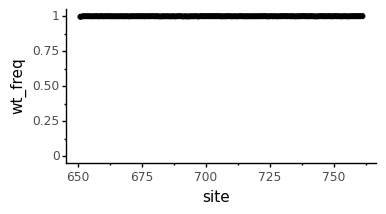

<ggplot: (8737340149017)>

In [14]:
wt_freq_plot = (
    p9.ggplot(freq_df,
              p9.aes(x='site',
                     y='wt_freq')) +
    p9.geom_point() +
    p9.ylim(0,1) +
    p9.theme(figure_size=(4, 2))
)
display(wt_freq_plot)

In [15]:
freq_df['wt_freq'].min()

0.9944192083062946